In [1]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
from utils import *

In [2]:
def leaky_integrate_neuron(U, time_step=1e-3, I=0, R=5e7, C=1e-10):
  tau = R*C
  U = U + (time_step/tau)*(-U + I*R)
  return U

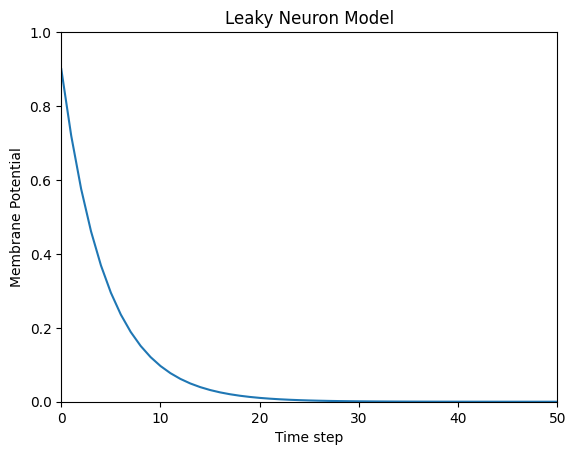

In [3]:
num_steps = 100
U = 0.9
U_trace = []

for step in range(num_steps):
    U_trace.append(U)
    U = leaky_integrate_neuron(U) # solve next step of U

plot_mem(U_trace, "Leaky Neuron Model")

In [4]:
time_step = 1e-3
R = 5 
C = 1e-3

#leaky integrate and fire neuron, tau=5e-3
lif1 = snn.Lapicque(R=R, C=C, time_step=time_step)

In [5]:
#initialize membrane, input and output 
mem = torch.ones(1) * 0.9

cur_in = torch.zeros(num_steps, 1) # I=0 for all t
spk_out = torch.zeros(1)

In [6]:
# a list to store a recording of membrane potential
mem_rec = [mem]


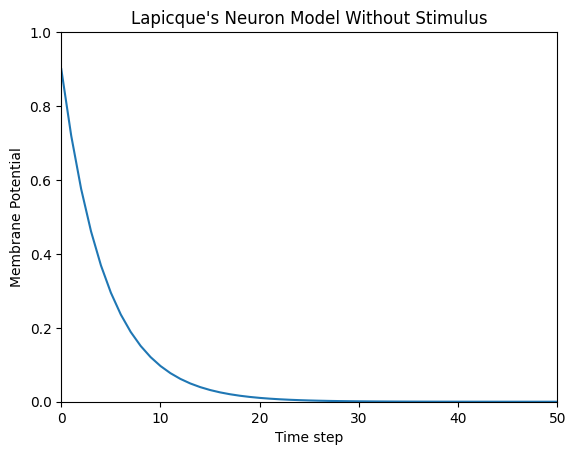

In [7]:
for step in range(num_steps):
    spk_out, mem = lif1(cur_in[step], mem)
    
    #store recordings of membrane potential
    mem_rec.append(mem)

# convert the list of tensors into one tensor
mem_rec = torch.stack(mem_rec)
plot_mem(mem_rec, "Lapicque's Neuron Model Without Stimulus")

In [8]:
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.1), 0)
# input current turns on at t=10

# Initialize membrane, output and recordings
mem = torch.zeros(1) # membrane potential of 0 at t=0
spk_out = torch.zeros(1) 
# neuron needs somewhere to sequentially dump its output spikes

mem_rec = [mem]

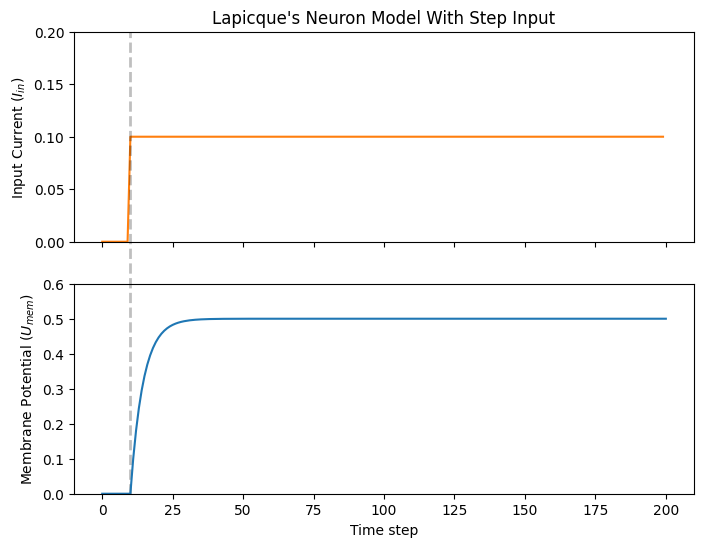

In [9]:
num_steps = 200

# pass update valude of mem and cur_in[step] at every time step
for step in range(num_steps):
    spk_out, mem = lif1(cur_in[step], mem)
    mem_rec.append(mem)

mem_rec = torch.stack(mem_rec)

plot_step_current_response(cur_in, mem_rec, 10)

In [10]:
print(f"The calculated value of input pulse [A] x resistance [Ω] is: {cur_in[11]*lif1.R} V")
print(f"The simulated value of steady-state membrane potential is: {mem_rec[200][0]} V")

The calculated value of input pulse [A] x resistance [Ω] is: tensor([0.5000]) V
The simulated value of steady-state membrane potential is: 0.4999999403953552 V


# 3.3 Lapicque: Pulse Input

In [11]:
# Initialize current pulse, membrane and outputs
cur_in1 = torch.cat((torch.zeros(10, 1), torch.ones(20, 1)*(0.1), torch.zeros(170, 1)), 0)  
# input turns on at t=10, off at t=30

mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec1 = [mem]


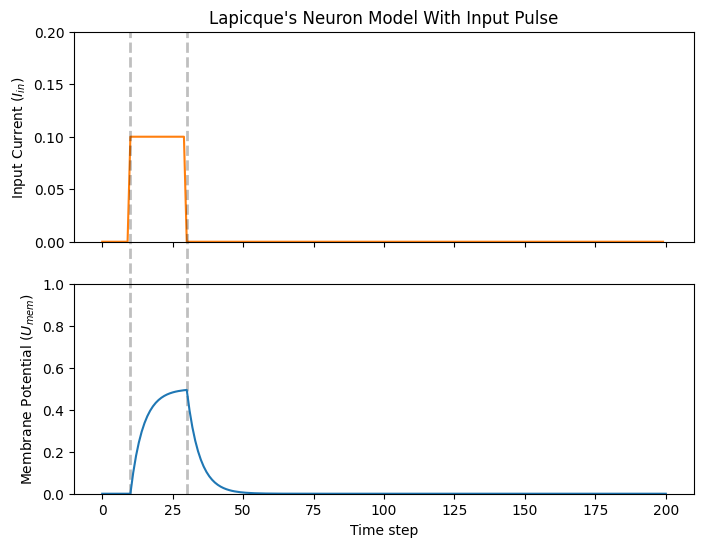

In [12]:
# neuron simulation
for step in range(num_steps):
    spk_out, mem = lif1(cur_in1[step], mem)
    mem_rec1.append(mem)

mem_rec1 = torch.stack(mem_rec1)

plot_current_pulse_response(cur_in1, mem_rec1, "Lapicque's Neuron Model With Input Pulse",
                            vline1=10, vline2=30)

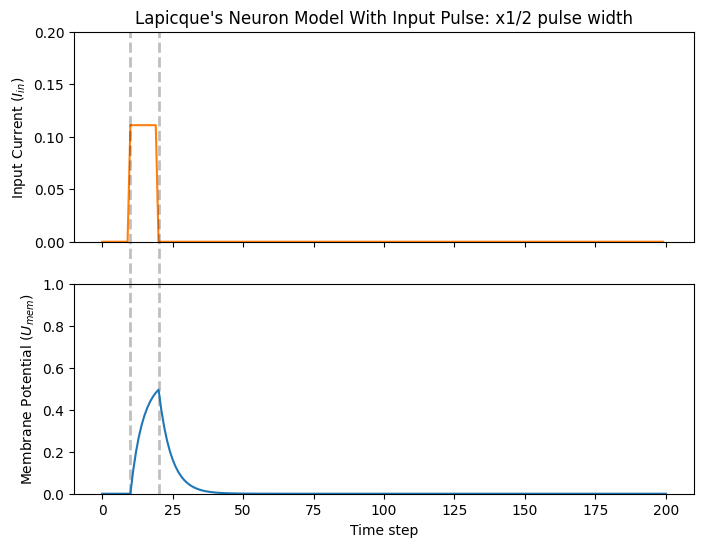

In [13]:
# Increase amplitude of current pulse; half the time.
cur_in2 = torch.cat((torch.zeros(10, 1), torch.ones(10, 1)*0.111, torch.zeros(180, 1)), 0)  # input turns on at t=10, off at t=20
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec2 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in2[step], mem)
  mem_rec2.append(mem)
mem_rec2 = torch.stack(mem_rec2)

plot_current_pulse_response(cur_in2, mem_rec2, "Lapicque's Neuron Model With Input Pulse: x1/2 pulse width",
                            vline1=10, vline2=20)

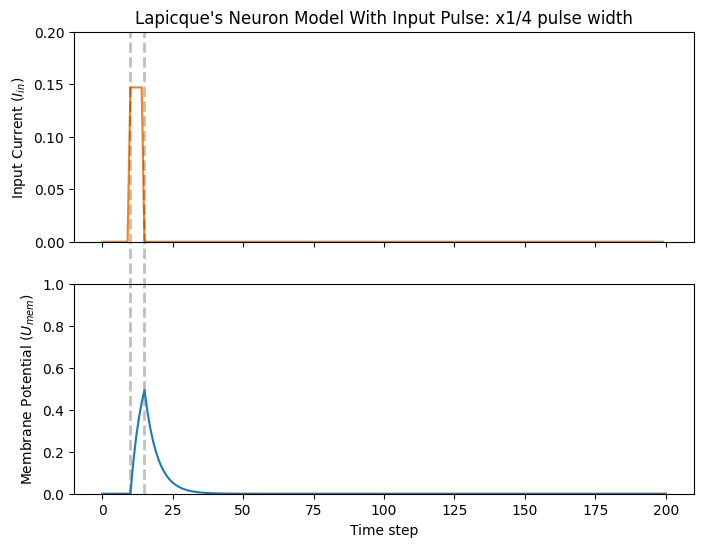

In [15]:
# Increase amplitude of current pulse; quarter the time.
cur_in3 = torch.cat((torch.zeros(10, 1), torch.ones(5, 1)*0.147, torch.zeros(185, 1)), 0)  # input turns on at t=10, off at t=15
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec3 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in3[step], mem)
  mem_rec3.append(mem)
mem_rec3 = torch.stack(mem_rec3)

plot_current_pulse_response(cur_in3, mem_rec3, "Lapicque's Neuron Model With Input Pulse: x1/4 pulse width",
                            vline1=10, vline2=15)

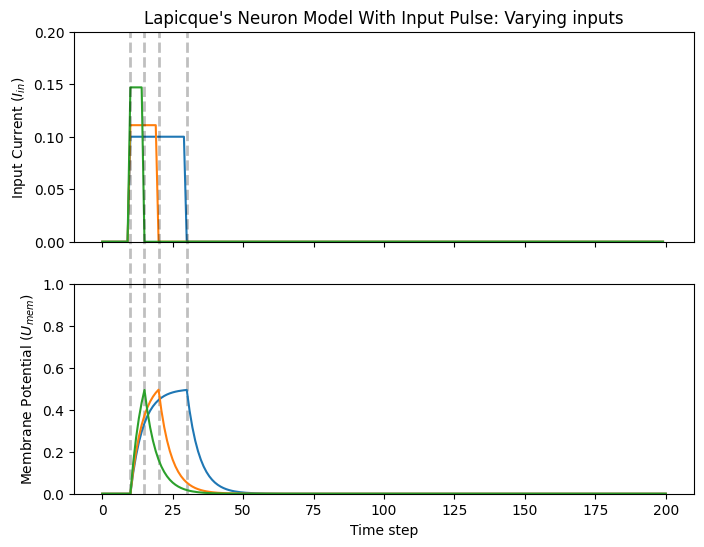

In [16]:
compare_plots(cur_in1, cur_in2, cur_in3, mem_rec1, mem_rec2, mem_rec3, 10, 15,
              20, 30, "Lapicque's Neuron Model With Input Pulse: Varying inputs")

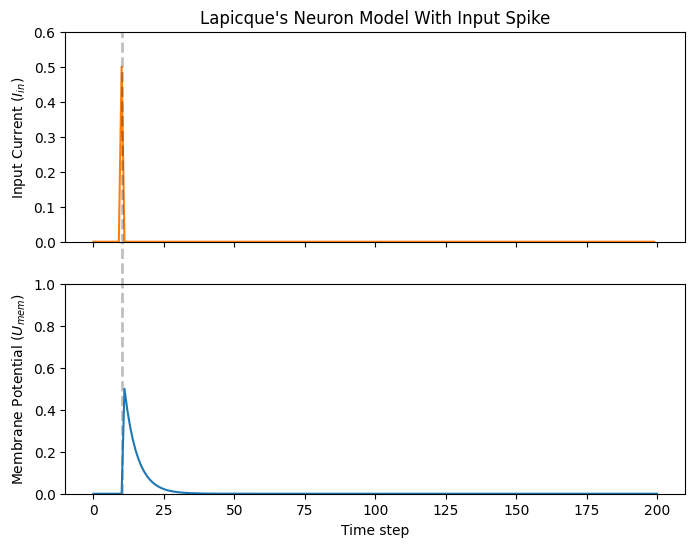

In [17]:
# Current spike input
cur_in4 = torch.cat((torch.zeros(10, 1), torch.ones(1, 1)*0.5, torch.zeros(189, 1)), 0)  # input only on for 1 time step
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec4 = [mem]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif1(cur_in4[step], mem)
  mem_rec4.append(mem)
mem_rec4 = torch.stack(mem_rec4)

plot_current_pulse_response(cur_in4, mem_rec4, "Lapicque's Neuron Model With Input Spike",
                            vline1=10, ylim_max1=0.6)

# 3.4 Lapicque: Firing

In [18]:
# R=5.1, C=5e-3 for illustrative purposes
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = mem + (time_step/tau_mem)*(-mem + cur*R)
  return mem, spk

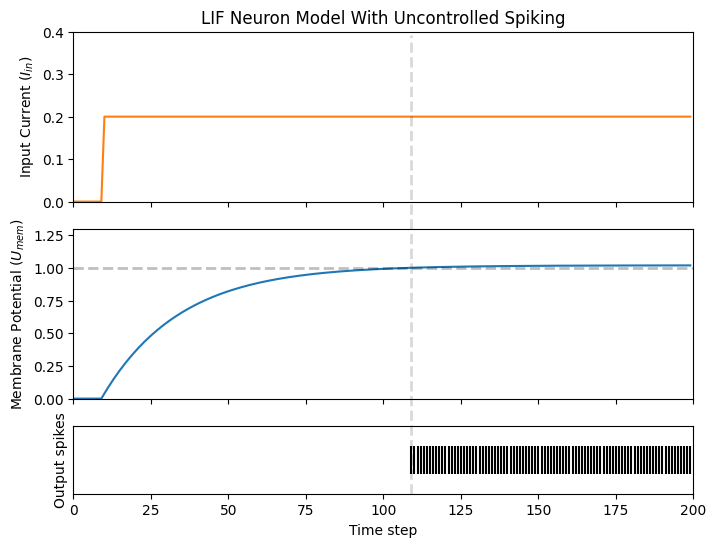

In [19]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Uncontrolled Spiking")

In [20]:
def leaky_integrate_and_fire(mem, cur=0, threshold=1, time_step=1e-3, R=5.1, C=5e-3):
  tau_mem = R*C
  spk = (mem > threshold)
  mem = mem + (time_step/tau_mem)*(-mem + cur*R) - spk*threshold  # every time spk=1, subtract the threhsold
  return mem, spk

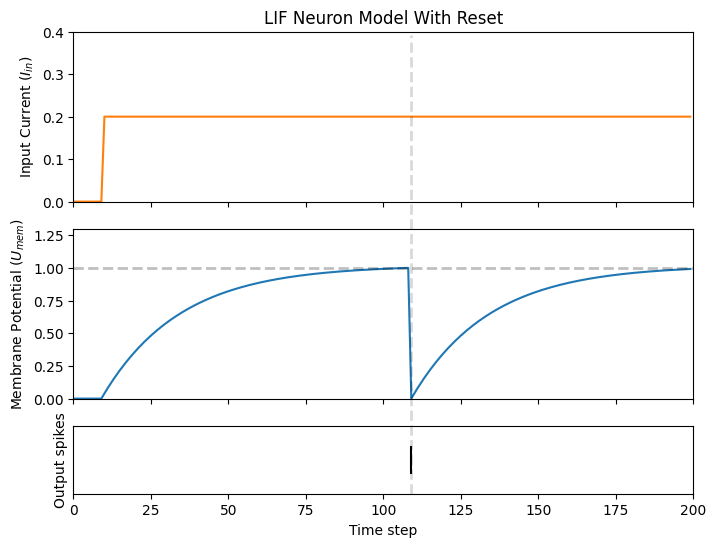

In [21]:
# Small step current input
cur_in = torch.cat((torch.zeros(10), torch.ones(190)*0.2), 0)
mem = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
  mem, spk = leaky_integrate_and_fire(mem, cur_in[step])
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="LIF Neuron Model With Reset")

In [22]:
lif2 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3)

print(f"Membrane potential time constant: {lif2.R * lif2.C:.3f}s")

Membrane potential time constant: 0.025s


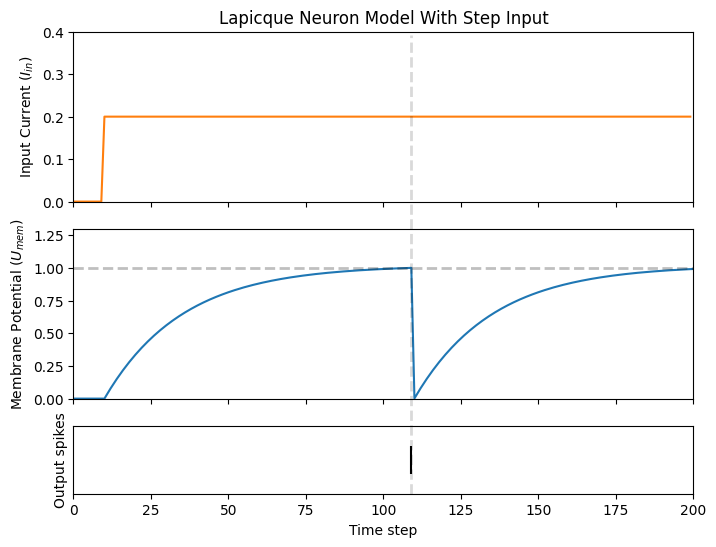

In [23]:
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.2), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Simulation run across 100 time steps.
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, vline=109, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Step Input")

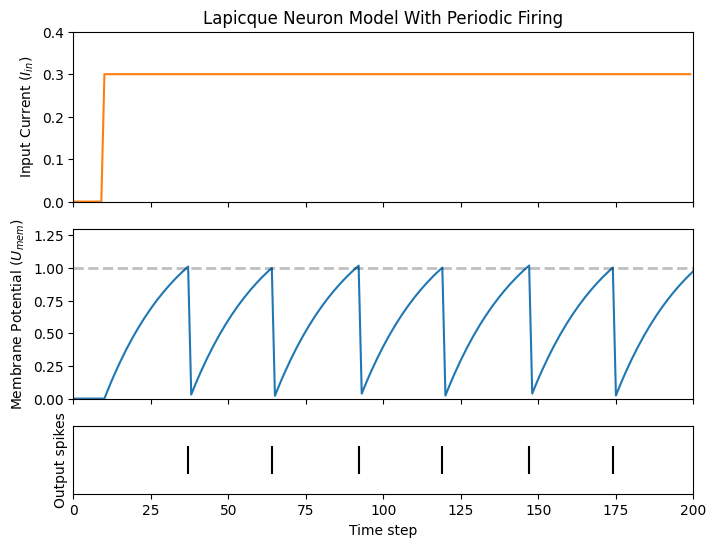

In [24]:
# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.3), 0)  # increased current
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# neuron simulation
for step in range(num_steps):
  spk_out, mem = lif2(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)


plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=1, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Periodic Firing")

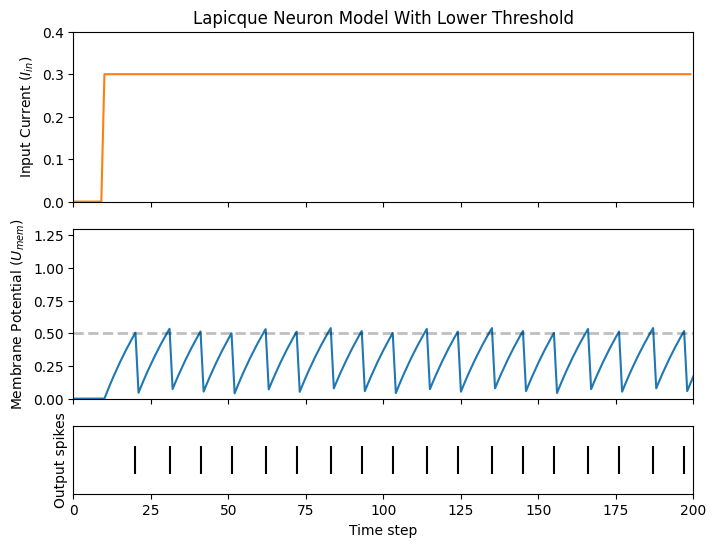

In [25]:
# neuron with halved threshold
lif3 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5)

# Initialize inputs and outputs
cur_in = torch.cat((torch.zeros(10, 1), torch.ones(190, 1)*0.3), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(cur_in[step], mem)
  mem_rec.append(mem)
  spk_rec.append(spk_out)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(cur_in, mem_rec, spk_rec, thr_line=0.5, ylim_max2=1.3,
                 title="Lapicque Neuron Model With Lower Threshold")

# Lapicque: Spike Inputs

In [26]:
# Create a 1-D random spike train. Each element has a probability of 40% of firing.
spk_in = spikegen.rate_conv(torch.ones((num_steps,1)) * 0.40)

In [27]:
print(f"There are {int(sum(spk_in))} total spikes out of {len(spk_in)} time steps.")

There are 82 total spikes out of 200 time steps.


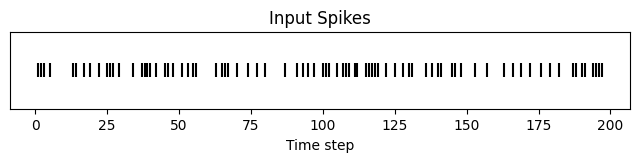

In [28]:
fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spk_in.reshape(num_steps, -1), ax, s=100, c="black", marker="|")
plt.title("Input Spikes")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

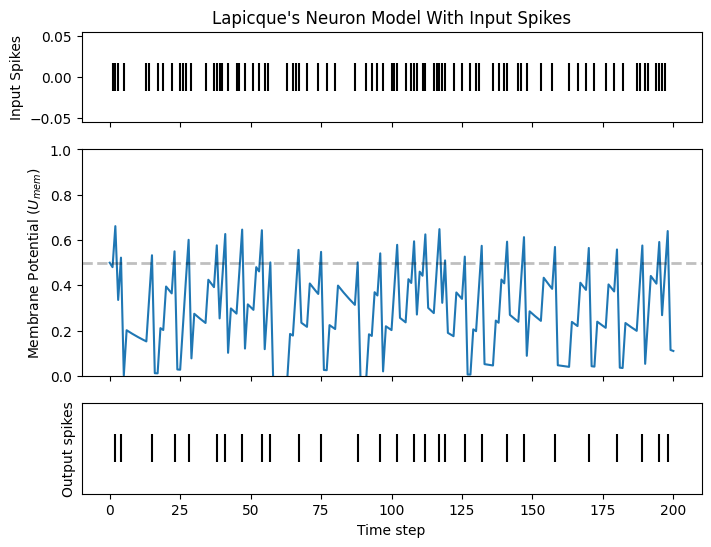

In [29]:
# Initialize inputs and outputs
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec = [mem]
spk_rec = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif3(spk_in[step], mem)
  spk_rec.append(spk_out)
  mem_rec.append(mem)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_spk_mem_spk(spk_in, mem_rec, spk_rec, "Lapicque's Neuron Model With Input Spikes")

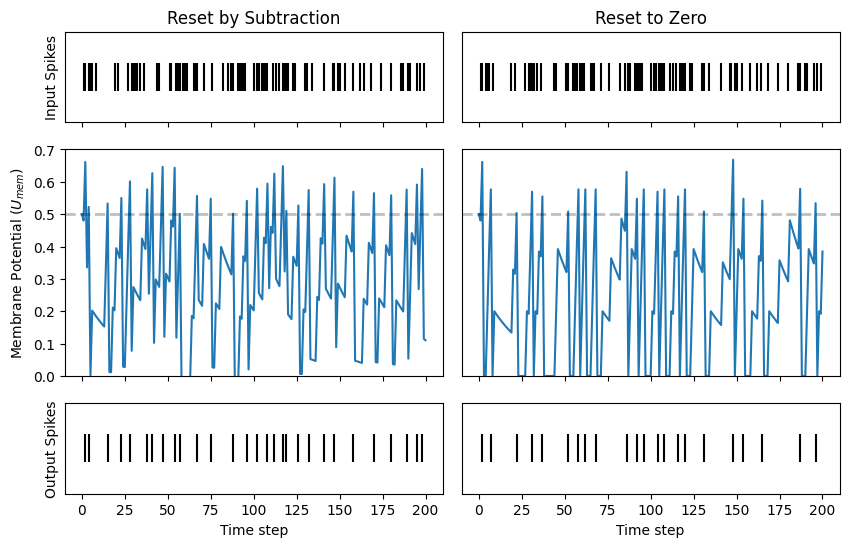

In [30]:
# Neuron with reset_mechanism set to "zero"
lif4 = snn.Lapicque(R=5.1, C=5e-3, time_step=1e-3, threshold=0.5, reset_mechanism="zero")

# Initialize inputs and outputs
spk_in = spikegen.rate_conv(torch.ones((num_steps, 1)) * 0.40)
mem = torch.ones(1)*0.5
spk_out = torch.zeros(1)
mem_rec0 = [mem]
spk_rec0 = [spk_out]

# Neuron simulation
for step in range(num_steps):
  spk_out, mem = lif4(spk_in[step], mem)
  spk_rec0.append(spk_out)
  mem_rec0.append(mem)

# convert lists to tensors
mem_rec0 = torch.stack(mem_rec0)
spk_rec0 = torch.stack(spk_rec0)

plot_reset_comparison(spk_in, mem_rec, spk_rec, mem_rec0, spk_rec0)